<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Visualization</div>

In [1]:
import sys, os

In [2]:
sys.path.append(os.path.abspath('../autoencoders'))

In [3]:
# "Magic" commands for automatic reloading of module, perfect for prototyping
%reload_ext autoreload
%autoreload 2

import wasserstein
import proteins
import visualization

In [4]:
import matplotlib.pyplot as plt

In [5]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [6]:
import numpy as np
import torch

# Paths

In [7]:
ROOT = '../'

In [8]:
MODULE_PATH = ROOT + 'autoencoders/'
DATA_PATH = ROOT + 'data/'
NOTEBOOK_PATH = ROOT + 'notebooks/'
MODELS_PATH = ROOT + 'models/'
GRAPHICS_PATH = ROOT + 'graphics/'

# Loading the model

In [11]:
model = proteins.WassersteinAutoEncoder(ksi=10.)
model.load_state_dict(torch.load(MODELS_PATH + 'wae.weights', map_location='cpu'))

# Dataset

In [12]:
complete_set = np.load(DATA_PATH + 'pgm-dataset.npy')

FileNotFoundError: [Errno 2] No such file or directory: '../data/pgm-dataset.npy'

In [90]:
prot = visualization.Protein(complete_set[0])

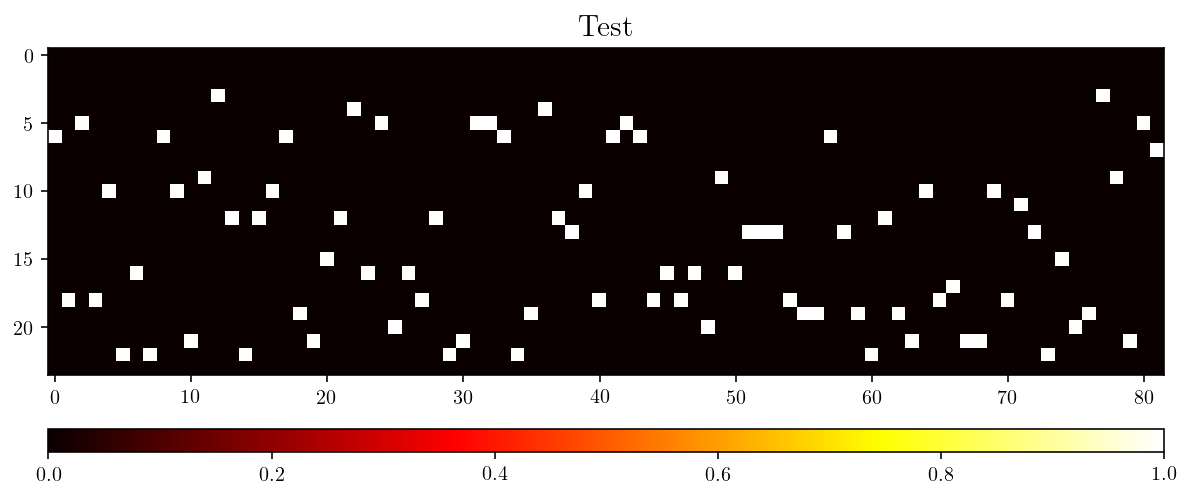

In [93]:
prot.plot_sequence(title='Test', save=GRAPHICS_PATH+'test-visualization.pdf')

In [94]:
with torch.no_grad():
    reconstruction, latent = model(torch.Tensor(complete_set[:100]))

In [95]:
reconstruction = np.array(reconstruction)

In [96]:
i = -1

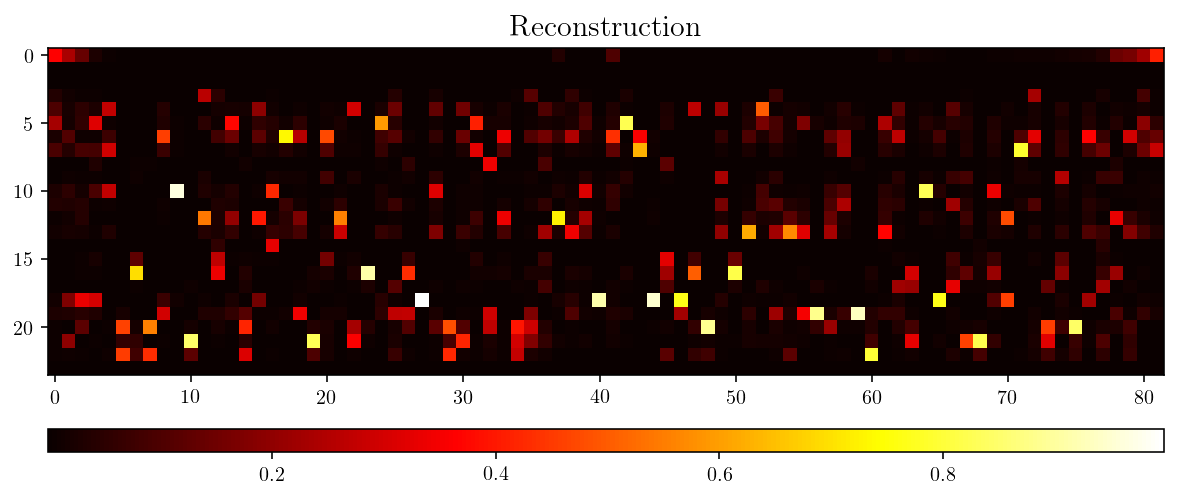

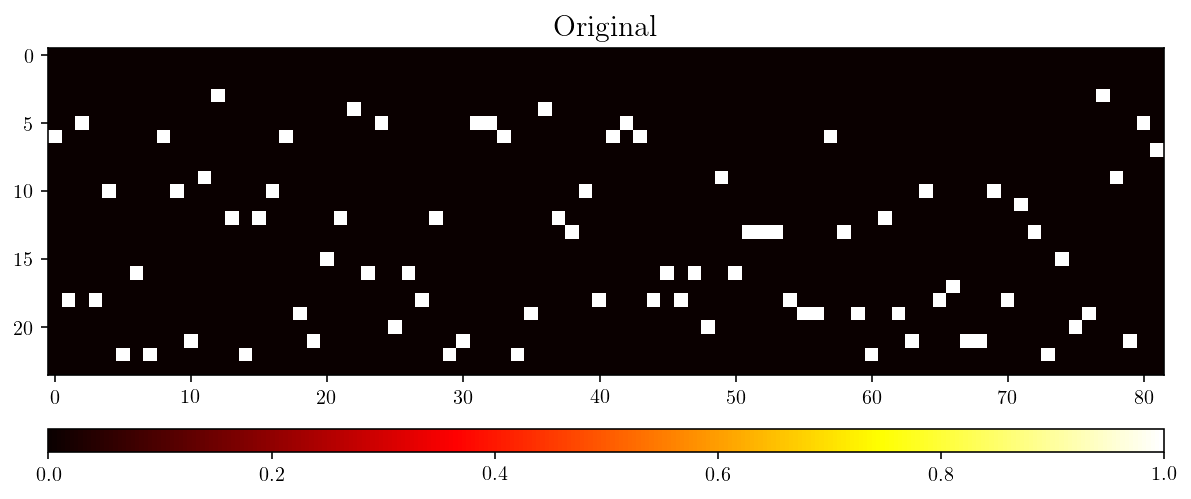

In [97]:
i += 1

prot = visualization.Protein(complete_set[i])
recon = visualization.Protein(reconstruction[i])

recon.plot_sequence(title='Reconstruction')
prot.plot_sequence(title='Original')